# Reinforcement Learning - Tic-Tac-Toe Agent

### By: Siddhant Pattanaik

## Tic-Tac-Toe Agent

In this notebook, an RL agent (using Q-learning) is trained that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
- Defining epsilon-greedy strategy
- Tracking state-action pairs for convergence
- Define hyperparameters for the Q-learning algorithm
- Generating episode and applying Q-update equation
- Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
# Setting up Google Colab for usage. Please disable if running locally.
import pathlib
import os
from google.colab import drive
drive.mount('/content/gdrive')
base_dir = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Reinforcement_Learning/Tic-Tac-Toe')
os.chdir(str(base_dir))

Mounted at /content/gdrive


In [2]:
from TCGame_Env import TicTacToe  #import your class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

# Importing tictactoe class
env = TicTacToe()

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

In [6]:
# printing the default tic tac toe board positions
Q_state(env.state)

'x-x-x-x-x-x-x-x-x'

In [7]:
# Printing all the valid actions
valid_actions(env.state)

[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 9),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 9),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 7),
 (4, 9),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 7),
 (5, 9),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 7),
 (6, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (8, 1),
 (8, 3),
 (8, 5),
 (8, 7),
 (8, 9)]

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [8]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    
    # Choosing a random number to choose between exploration and exploitation based on value of epsilon
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation. Get the action corresponding to max q-value of current state
    else:
        agent_actions, env_actions = env.action_space(state)
        action = random.choice(list(agent_actions))           #Exploration: randomly choosing and action
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [9]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [10]:
# Initialise states to be tracked
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(8,7)),
                       ('x-x-x-x-x-6-x-x-9',(4,5)),('5-x-x-x-6-x-x-x-x',(1,9))]    
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []  

In [11]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [12]:
#Defining a function to save the tracked states
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [13]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [14]:
EPISODES = 500000
LR = 0.02                  # learning rate
GAMMA = 0.9                # discount factor

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.002       # epsilon decay rate
threshold = 200          # no of episodes after which states_tracked will be saved
policy_threshold = 300   # no of episodes after which Q dictionary/table will be saved

### Q-update loop ---write your code here

In [19]:
import time
start_time = time.time()
episode_count = 0
win_count = 0
loss_count = 0
tie_count = 0

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe()
    curr_state = env.state
    is_terminated = False
    add_to_dict(curr_state)
    total_reward = 0
    episode_count += 1
    
    # Run loop till we reach terminal state
    while not is_terminated:
        current_state_element = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, is_terminated = env.step(curr_state, curr_action)

        next_state_element = Q_state(next_state)
        add_to_dict(next_state)
        
        # Calculate action value function based on whether it is terminal state or not, taking learning rate into account.
        if is_terminated:
            Q_dict[current_state_element][curr_action] += LR * ((reward - Q_dict[current_state_element][curr_action]))
        else:
            max_next = max(Q_dict[next_state_element], key=Q_dict[next_state_element].get)
            Q_dict[current_state_element][curr_action] += LR * ((reward + (GAMMA * (Q_dict[next_state_element][max_next]))) - 
                                                                                    Q_dict[current_state_element][curr_action])

        curr_state = next_state
        total_reward += reward

    if total_reward > 0:
        win_count += 1
    elif total_reward < -10:
        loss_count += 1
    else:
        tie_count += 1
    
    
    # Tracking the states and policy
    if ((episode+1) % threshold) == 0:                # every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked_6')     # Save states tracked in pickle file

    if ((episode+1)% policy_threshold ) == 0:         # every 3000th episodes
        save_obj(Q_dict,'Policy_6')                   # Save the policy as in Q_dict i pickle file.
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked_6')   
save_obj(Q_dict,'Policy_6')
print(elapsed_time) 

784.1657674312592


#### Check the Q-dictionary

In [20]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.8228496430170699,
              (0, 3): -0.8751795349483056,
              (0, 5): -0.8638524441052469,
              (0, 7): -1.0316351085769286,
              (0, 9): -1.1132553011601671,
              (1, 1): -0.8434244159499797,
              (1, 3): -0.8654516399958633,
              (1, 5): -0.8441169251899355,
              (1, 7): -1.0167323655329845,
              (1, 9): -1.1276643195711875,
              (2, 1): -0.8644345770790386,
              (2, 3): -0.862653061292173,
              (2, 5): -0.8409356379489138,
              (2, 7): -1.2209370434630193,
              (2, 9): -1.1387525154174216,
              (3, 1): -0.8285342733275568,
              (3, 3): -0.8309514755187266,
              (3, 5): -0.8582718982020818,
              (3, 7): -1.1444943006488317,
              (3, 9): -1.2776258958853772,
              (4, 1): -0.8722969020856063,
              (4, 3): -0.8566416093627889,
              (4

In [21]:
len(Q_dict)

54129

In [22]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
States_track['x-x-x-x-x-x-x-x-x'][(6,5)]

[-0.058808,
 -0.16625223786985013,
 -0.2614308973545961,
 -0.34574418768000736,
 -0.4204324735203474,
 -0.4865945224718052,
 -0.5452036694378051,
 -0.6051796930120429,
 -0.6502514392443327,
 -0.6963743441917135,
 -0.7310355261673941,
 -0.7617398701322914,
 -0.7931602977071628,
 -0.8167726256637121,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.8275478610936805,
 -0.82754786109368

In [23]:
print("No. of total episodes: ",episode_count)
print("No.of episodes won by agent: ",win_count)
print("No. of episodes won by environment: ",loss_count)
print("No. of tied games: ",tie_count)
print("\nPercentage wins by our agent: ",round(100 * win_count/episode_count,2),"%")

No. of total episodes:  500000
No.of episodes won by agent:  453289
No. of episodes won by environment:  18166
No. of tied games:  28545

Percentage wins by our agent:  90.66 %


#### Check the states tracked for Q-values convergence
(non-evaluative)

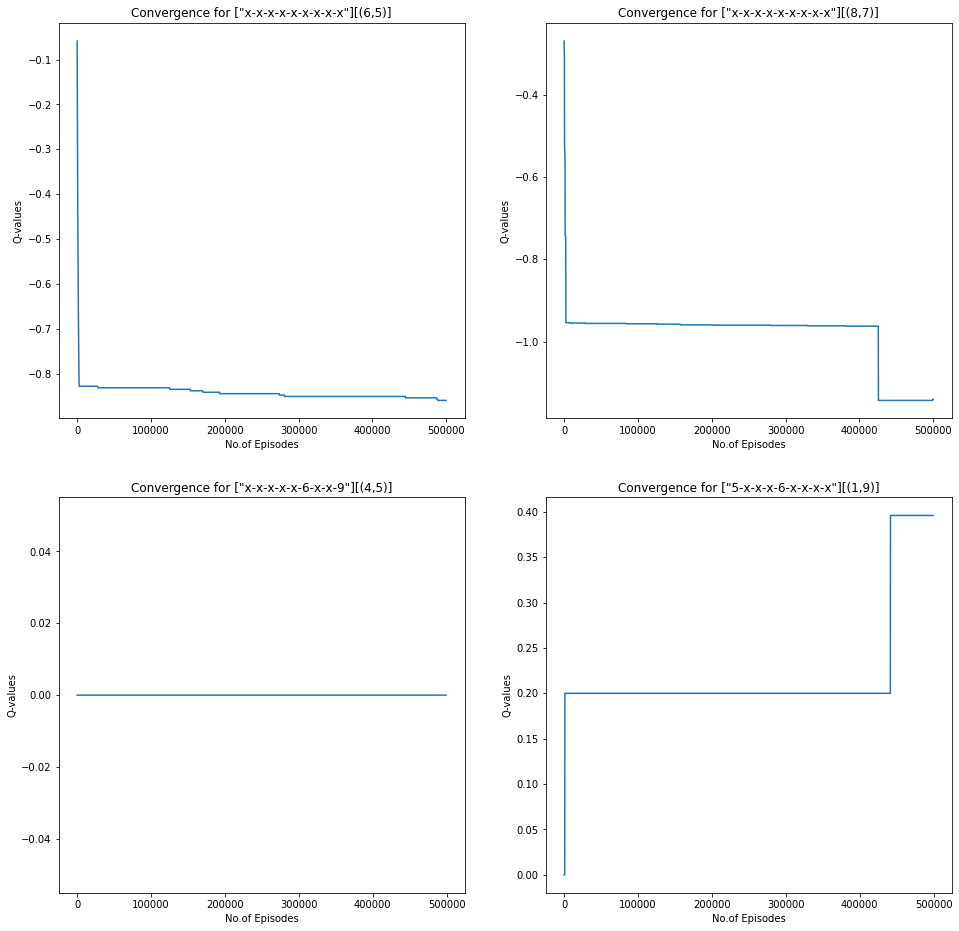

In [24]:
# Write the code for plotting the graphs for state-action pairs tracked
plt.figure(0, figsize=(16,16))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
plt.subplot(221)
plt.plot(x_axis*threshold,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)]))
plt.xlabel("No.of Episodes")
plt.ylabel("Q-values")
plt.title('Convergence for ["x-x-x-x-x-x-x-x-x"][(6,5)]')


plt.figure(0, figsize=(16,7))
x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(8,7)])))
plt.subplot(222)
plt.plot(x_axis*threshold,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(8,7)]))
plt.xlabel("No.of Episodes")
plt.ylabel("Q-values")
plt.title('Convergence for ["x-x-x-x-x-x-x-x-x"][(8,7)]')

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-6-x-x-9'][(4,5)])))
plt.subplot(223)
plt.plot(x_axis*threshold,np.asarray(States_track['x-x-x-x-x-6-x-x-9'][(4,5)]))
plt.xlabel("No.of Episodes")
plt.ylabel("Q-values")
plt.title('Convergence for ["x-x-x-x-x-6-x-x-9"][(4,5)]')


x_axis = np.asarray(range(0, len(States_track['5-x-x-x-6-x-x-x-x'][(1,9)])))
plt.subplot(224)
plt.plot(x_axis*threshold,np.asarray(States_track['5-x-x-x-6-x-x-x-x'][(1,9)]))
plt.xlabel("No.of Episodes")
plt.ylabel("Q-values")
plt.title('Convergence for ["5-x-x-x-6-x-x-x-x"][(1,9)]')

plt.show()

### Epsilon - decay check

In [25]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,EPISODES)
epsilon = []
for i in range(0,EPISODES):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*i))

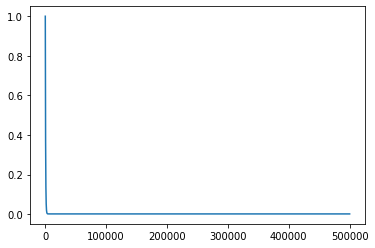

In [26]:
plt.plot(time, epsilon)
plt.show()

In [28]:
# Checking states tracking pickle file
infile = open('States_tracked_6.pkl','rb')
new_dict = pickle.load(infile)
infile.close()
print(new_dict)

defaultdict(<class 'dict'>, {'x-x-x-x-x-x-x-x-x': {(6, 5): [-0.058808, -0.16625223786985013, -0.2614308973545961, -0.34574418768000736, -0.4204324735203474, -0.4865945224718052, -0.5452036694378051, -0.6051796930120429, -0.6502514392443327, -0.6963743441917135, -0.7310355261673941, -0.7617398701322914, -0.7931602977071628, -0.8167726256637121, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.8275478610936805, -0.